In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random, numpy as np
from google.colab import files
import zipfile
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# sets random seed to ensure reproducibility
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# make cuDNN deterministic and enforce deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

files.upload();

Saving Pistachio_Image_Dataset.zip to Pistachio_Image_Dataset (1).zip


In [9]:
with zipfile.ZipFile("Pistachio_Image_Dataset.zip", "r") as zip_data:
  zip_data.extractall("data")

In [16]:
# used a series of transformations on the training data, prevents model overfitting (memorizing training data)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128),      # random crop, keeps aspect ratio
    transforms.RandomHorizontalFlip(),      # flip image randomly
    transforms.RandomRotation(15),          # rotate image randomly
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# did not transform the test data to ensure consistent evaluation and create a fixed benchmark
test_transform = transforms.Compose([
    transforms.Resize(140),                 # resize image
    transforms.CenterCrop(128),             # center crop
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# load the dataset from the data folder
full_dataset = datasets.ImageFolder("data", transform=None)

# splitting the data into the three required sets
num_samples = len(full_dataset) # gets the number of samples
indices = np.arange(num_samples) # creates an array that represents the position of each image

# randomly shuffles the indices and ensures more random splitting with fixed seed
rng = np.random.RandomState(seed)
rng.shuffle(indices)

train_end = int(0.7 * num_samples) # takes the first 70% as training data
valid_end = int(0.85 * num_samples) # takes the second 15% as validation data

train_idx = indices[:train_end]
valid_idx = indices[train_end:valid_end]
test_idx  = indices[valid_end:] # takes the last 15% as testing data

# loads and creates each subset (using the _idx variables) and applies the appropriate transformations
train_dataset = Subset(datasets.ImageFolder("data", transform=train_transform), train_idx)
valid_dataset = Subset(datasets.ImageFolder("data", transform=test_transform), valid_idx)
test_dataset  = Subset(datasets.ImageFolder("data", transform=test_transform), test_idx)

# Creates the DataLoaders, making batches of data and shuffles the training dataset to reduce overfitting
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ensures that the class names are correct -> Kirmizi_Pistachio and Siirt_Pistachio
full_dataset = datasets.ImageFolder("data", transform=None)
print(full_dataset.classes)

['Kirmizi_Pistachio', 'Siirt_Pistachio']


In [11]:
# Documentation of CNN used is on https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# results in 2 classes
num_classes = len(full_dataset.classes)

# defines a custom neural network class
class PistachioClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers -> creates a 2D convolution layer using 3 channels for RGB
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers -> the 128x128 images become 16x16 after 3 pool layers
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    # defines how data flows through the network
    def forward(self, x):
        x = F.relu(self.conv1(x)) # applies conv1 and ReLU
        x = self.pool(x) # applies max pooling
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, 1) # flattens all dimensions except batch size
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # outputs raw scores
        return x

# initialize the network
classifier = PistachioClassifier()
print(classifier)

PistachioClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [14]:
# loss function that measures how "wrong" the model's predictions are
class_counts = torch.tensor([853, 650], dtype=torch.float)
weights = 1.0 / class_counts  # inverse frequency
weights = weights / weights.sum()  # normalize

criterion = nn.CrossEntropyLoss(weight=weights)

# updates model weights using Adam, initially sgd but switched
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# the number of epochs is the amount of times the model will pass through the entire training dataset -> used 30 to ensure accuracy is better
num_epochs = 30

for epoch in range(num_epochs):
    classifier.train()  # sets the model to training mode
    train_loss_history = 0.0 # keeps track of total loss for the epoch

    for inputs, labels in train_loader:
        # resets the gradients
        optimizer.zero_grad()

        # forward pass and compute loss
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)

        # backward pass and optimize
        loss.backward()
        optimizer.step()

        #accumulate loss
        train_loss_history += loss.item()

    # calculates the average loss, allowing for easier comparison across epochs
    avg_train_loss = train_loss_history / len(train_loader)

    # validation loss
    classifier.eval()  # set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad(): # no gradients calculated, computes loss only
        for inputs, labels in val_loader:
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print("Finished Training")

Epoch 1/30 | Train Loss: 0.3972 | Val Loss: 0.2766
Epoch 2/30 | Train Loss: 0.3782 | Val Loss: 0.2403
Epoch 3/30 | Train Loss: 0.3773 | Val Loss: 0.2018
Epoch 4/30 | Train Loss: 0.3834 | Val Loss: 0.2061
Epoch 5/30 | Train Loss: 0.3668 | Val Loss: 0.2941
Epoch 6/30 | Train Loss: 0.3740 | Val Loss: 0.2993
Epoch 7/30 | Train Loss: 0.3812 | Val Loss: 0.2043
Epoch 8/30 | Train Loss: 0.3618 | Val Loss: 0.2160
Epoch 9/30 | Train Loss: 0.3625 | Val Loss: 0.3230
Epoch 10/30 | Train Loss: 0.3540 | Val Loss: 0.2261
Epoch 11/30 | Train Loss: 0.3676 | Val Loss: 0.2065
Epoch 12/30 | Train Loss: 0.3514 | Val Loss: 0.2662


KeyboardInterrupt: 

Test Accuracy: 0.8947


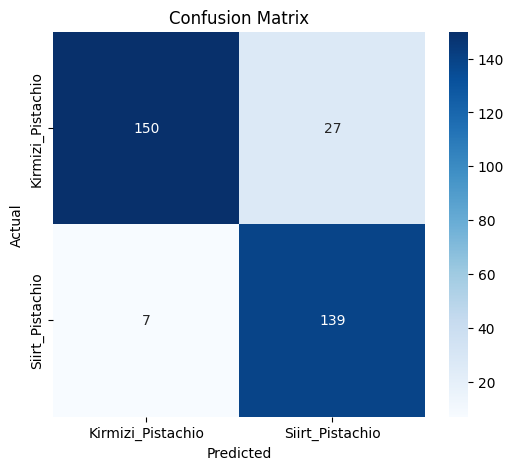

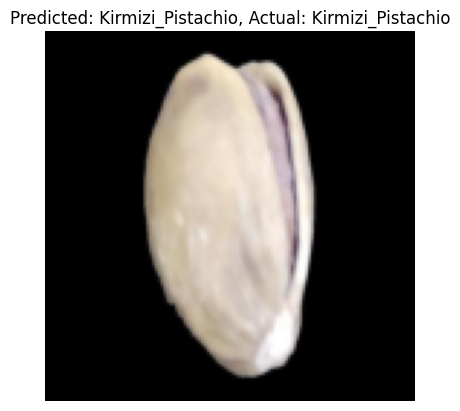

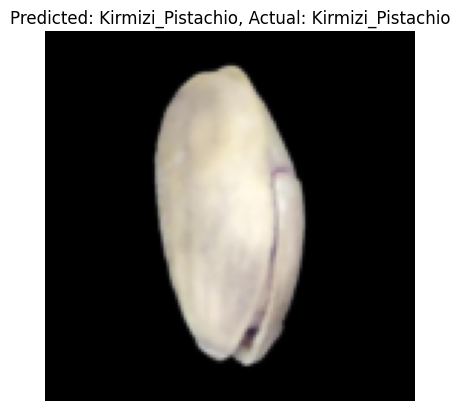

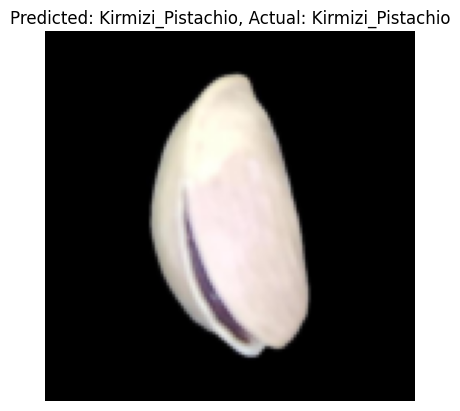

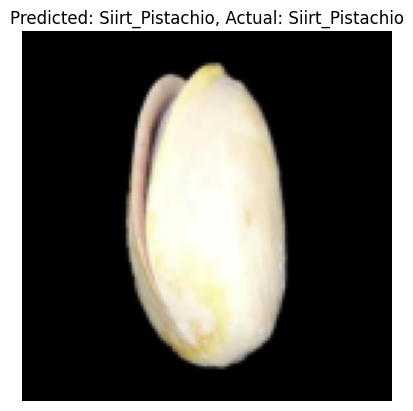

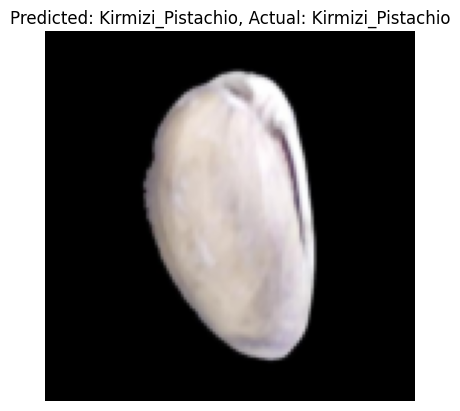

In [13]:
# sets the model to evaluation mode and counts the number of correct predictions
classifier.eval()
test_corrects = 0

# stores all the real and predicted labels
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = classifier(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels).item()

        # used for confusion matrix
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.numpy())

# showcases overall model performance, correct performance / total count of dataset
test_acc = test_corrects / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# counts correct/incorrect for both classes
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))

#visualizes the results as a table -> confusion matrix
sns.heatmap(cm, annot=True, fmt="d", xticklabels=full_dataset.classes, yticklabels=full_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# converts the images back to a viewable format
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title: # shows the images with a title
        plt.title(title)
    plt.axis('off')
    plt.show()

# gets a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = classifier(images)
_, preds = torch.max(outputs, 1)

# visualizes the first five test images with corresponding predictions and real labels
for i in range(5):
    imshow(images[i], title=f"Predicted: {full_dataset.classes[preds[i]]}, Actual: {full_dataset.classes[labels[i]]}")